# Tutorial 1: Generalization in AI

**Week 1, Day 1: Generalization**

**By Neuromatch Academy**

__Content creators:__ Names & Surnames

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


___


# Tutorial Objectives

*Estimated timing of tutorial: [insert estimated duration of whole tutorial in minutes]*

By the end of this tutorial, participants will be able to:

1. Identify and articulate common objectives pursued by developers of operational AI systems, such as:

- Performance, latency, Size, Weight, Power, and Cost (SWaP-C)
- Achieving explainability and comprehension

2. Explain at least three strategies for enhancing the generalization capabilities of AI systems, including the contemporary trend of training generic models on extensive datasets, commonly referred to as the "bitter lesson."

3. Gain practical experience with the fundamentals of deep learning and PyTorch.



In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


---
# Setup



In [2]:
# @title Install dependencies
# @markdown

#!pip install numpy Pillow matplotlib torch torchvision transformers gradio sentencepiece protobuf
#!pip install git+https://github.com/Belval/TextRecognitionDataGenerator#egg=trdg

In [3]:
# @title Import dependencies
# @markdown

# Standard Libraries for file and operating system operations, security, and web requests
import os
import hashlib
import requests
import logging
import io

# Core python data science and image processing libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Deep Learning and model specific libraries
import torch
import transformers
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import google.protobuf

# Utility and interface libraries
import gradio as gr
from IPython.display import IFrame
import trdg
from trdg.generators import GeneratorFromStrings
import sentencepiece
import zipfile

Missing modules for handwritten text generation.


In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions
# @markdown

def display_image(image_path):
    """Display an image from a given file path.

    Inputs:
    - image_path (str): The path to the image file.
    """
    # Open the image
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()

def display_transformed_images(image, transformations):
    """
    Apply a list of transformations to an image and display them.

    Inputs:
    - image (Tensor): The input image as a tensor.
    - transformations (list): A list of torchvision transformations to apply.
    """
    # Convert tensor image to PIL Image for display
    pil_image = transforms.ToPILImage()(image)

    fig, axs = plt.subplots(len(transformations) + 1, 1, figsize=(5, 15))
    axs[0].imshow(pil_image)
    axs[0].set_title('Original')
    axs[0].axis('off')

    for i, transform in enumerate(transformations):
        # Apply transformation if it's not the placeholder
        if transform != "Custom ElasticTransform Placeholder":
            transformed_image = transform(image)
            # Convert transformed tensor image to PIL Image for display
            display_image = transforms.ToPILImage()(transformed_image)
            axs[i+1].imshow(display_image)
            axs[i+1].set_title(transform.__class__.__name__)
            axs[i+1].axis('off')
        else:
            axs[i+1].text(0.5, 0.5, 'ElasticTransform Placeholder', ha='center')
            axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_original_and_transformed_images(original_tensor, transformed_tensor):
    """
    Display the original and transformed images side by side.

    Inputs:
    - original_tensor (Tensor): The original image as a tensor.
    - transformed_tensor (Tensor): The transformed image as a tensor.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    original_image = original_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[0].imshow(original_image)
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Display transformed image
    transformed_image = transformed_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[1].imshow(transformed_image)
    axs[1].set_title('Transformed')
    axs[1].axis('off')

    plt.show()

def display_generated_images(generator):
    """
    Display images generated from strings.

    Inputs:
    - generator (GeneratorFromStrings): A generator that produces images from strings.
    """
    plt.figure(figsize=(15, 3))
    for i, (text_img, lbl) in enumerate(generator, 1):
        ax = plt.subplot(1, len(generator.strings) * generator.count // len(generator.strings), i)
        plt.imshow(text_img)
        plt.title(f"Example {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# @title Data retrieval
# @markdown

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.

    Inputs:
    - fname (str): The local filename/path to save the downloaded file.
    - url (str): The URL from which to download the file.
    - expected_md5 (str): The expected MD5 checksum to verify the integrity of the downloaded data.
    """
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url)  # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content)  # Write the downloaded content to a file
                print(f"{fname} has been downloaded successfully.")

# Variables for the font file and download URL
fname = "Dancing_Script.zip"
url = "https://osf.io/32yed/download"
expected_md5 = "d59bd3201b58a37d0d3b4cd0b0ec7400"

# Download the font file
download_file(fname, url, expected_md5)

def extract_zip(zip_fname):
    """
    Extracts a ZIP file to the current directory.

    Inputs:
    - zip_fname (str): The filename/path of the ZIP file to be extracted.
    """
    with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
        zip_ref.extractall(".")

# Extract the downloaded ZIP file
extract_zip(fname)

def download_image(fname, url, expected_md5):
    """
    Downloads an image file from the given URL and saves it locally.

    Inputs:
    - fname (str): The local filename/path to save the downloaded image.
    - url (str): The URL from which to download the image.
    - expected_md5 (str): The expected MD5 checksum to verify the integrity of the downloaded data.
    """
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

# Variables for file and download URL
fnames = ["img_1235.jpg", "image_augmentation.png"]  # The names of the files to be downloaded
urls = ["https://osf.io/kv5bx/download", "https://osf.io/fqwsr/download"]  # URLs from where the files will be downloaded
expected_md5s = ["920ae567f707bfee0be29dc854f804ed", "f4f1ebee1470a7e2d7662eec1d193ba2"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    download_image(fname, url, expected_md5)

Dancing_Script.zip has been downloaded successfully.


## Video and background

### Missing

## Activity 1: Introducing the TrOCR (Transformer-based Optical Character Recognition) Model

Before diving into the specifics of the TrOCR model, it's crucial to have a solid understanding of the underlying technology that powers it: transformers. Transformers are a class of deep learning models that have revolutionized the field of natural language processing (NLP) since their introduction in the paper "Attention is All You Need" by Vaswani et al. in 2017. Their success in NLP has led to their application across a variety of domains, including computer vision, which is the case with TrOCR.

### Key Concepts of Transformers

Transformers are built on the principle of self-attention, allowing them to weigh the importance of different parts of the input data differently. This is particularly beneficial for tasks that require an understanding of the context, such as language translation, text summarization, and, as we will see, optical character recognition. The key components of transformers are:

- A self-Attention mechanism allows the model to focus on different parts of the input sequence when producing a specific part of the output sequence. For OCR, this means the model can learn to focus on specific parts of an image when trying to recognize characters or words.

- Positional Encoding is added to the input to give the model information about the position of each part of the sequence (or each pixel/region in the case of images), because transformers do not process data in order (like RNNs or CNNs).

- An Encoder-Decoder architecture is followed. The encoder processes the input data and captures its context, while the decoder generates the output sequence, one element at a time. In the context of TrOCR, the encoder would process the image, and the decoder would generate the text.

- Layer Normalization and Residual Connections are used within the transformer architecture to stabilize the learning process and improve the model's ability to learn deep representations without degradation.

### TrOCR and Transformers

TrOCR leverages these transformer principles by integrating them into a model tailored for optical character recognition. It features an encoder for image processing (vision component) and a decoder for text generation (language component). This amalgamation enables TrOCR to bridge the gap between visual and textual data effectively, rendering it a potent tool for transmuting images of text into machine-readable text.

The initial step involves loading the pre-trained TrOCR model and its corresponding processor. The model VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten") specializes in recognizing handwritten text, while the TrOCRProcessor prepares input images and decodes model predictions into human-readable text. This showcases the seamless accessibility and utilization of advanced machine learning models with minimal code.

In [7]:
# Load the pre-trained TrOCR model and processor
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


With the model loaded, the next step involves defining a function utilizing the pre-trained model for Optical Character Recognition (OCR) to convert an image to text. This function preprocesses the image to meet the model's input requirements, predicts text as token IDs, decodes these tokens into human-readable text while excluding special tokens, and returns the recognized text.

In [8]:
# Define the function to recognize text from an image
def recognize_text(image):
    """
    This function takes an image as input and uses a pre-trained language model to generate text from the image.

    Inputs:
    - image (PIL Image or Tensor): The input image containing text to be recognized.

    Outputs:
    - text (str): The recognized text extracted from the input image.
    """
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

Subsequently, Gradio is employed to craft an interactive web interface for the TrOCR demonstration. Gradio, a Python library, simplifies the creation of UIs for machine learning models. This interface facilitates image uploads and displays recognized text, allowing users to interactively explore the model's capabilities.

In [9]:
# Create a Gradio interface
interface = gr.Interface(
    fn=recognize_text,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Interactive demo: TrOCR",
    description="Demo for Microsoft’s TrOCR, an encoder-decoder model for OCR on single-text line images.",
)

# Launch the interface
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### Discussion point

How effective is the model's performance? Does it exhibit generalization beyond its training vocabulary?

## Activity 2: Inspecting the Model's Encoder and Decoder

By inspecting the model's encoder and decoder, we gain insight into the inner workings of the TrOCR model. The encoder processes the input images, and the decoder generates text predictions. This step is crucial for understanding the model architecture and the roles of its components in the text recognition process.

In [10]:
# Inspect the encoder of the model
model.encoder

DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0-11): 12 x DeiTLayer(
        (attention): DeiTAttention(
          (attention): DeiTSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUAc

### Coding exercise

In the cell below, inspect the decoder of the model.

In [11]:
model.decoder

TrOCRForCausalLM(
  (model): TrOCRDecoderWrapper(
    (decoder): TrOCRDecoder(
      (embed_tokens): Embedding(64044, 256, padding_idx=1)
      (embed_positions): TrOCRLearnedPositionalEmbedding(514, 256)
      (layernorm_embedding): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x TrOCRDecoderLayer(
          (self_attn): TrOCRAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): TrOCRAttention(
            (k_proj): Linear(in_features=384, out_features=256, bias=True)
            (v_proj): Linear(in_features=384, out_feat

### Follow-up coding exercise 

Now, let's create a count_parameters function to compute the total number of parameters in the model, offering an understanding of its complexity. Analyzing parameters separately in the encoder and decoder aids in comprehending the distribution of model complexity and its impact on training and inference.

In [12]:
# Function to count the parameters of the model
def count_parameters(model):
    """
    This function calculates the total number of parameters in a given PyTorch model.

    Inputs:
    - model (torch.nn.Module): The PyTorch model for which parameters are to be counted.

    Outputs:
    - num_parameters (int): The total number of parameters in the specified model.
    """
    return sum(p.numel() for p in model.parameters())

# Count parameters in the encoder
encoder_params = count_parameters(model.encoder)

# Count parameters in the decoder
decoder_params = count_parameters(model.decoder)

encoder_params, decoder_params

(21960192, 39636480)

### Written exercise

Look at the available variants of this model (i.e. small, base, large). How do these models trade off in terms of accuracy vs. inference latency? 

### Discussion point

Models like TrOCR embed various inductive biases that influence their learning and decision-making processes. Some of these biases include:

- Spatial bias: given the nature of OCR tasks, TrOCR is biased towards recognizing spatial patterns in images, such as the arrangement of characters and words.

- Linguistic bias: the model is predisposed to leveraging linguistic structures and semantics when generating text predictions, reflecting the inherent properties of language.

- Contextual bias: TrOCR incorporates contextual information from both the input image and previously generated text tokens to make accurate predictions, reflecting the importance of context in text recognition tasks.

- Attention mechanism bias: the self-attention mechanism in transformers biases the model towards attending to relevant parts of the input data, facilitating effective feature extraction and information integration.

Understanding these inductive biases is crucial for interpreting the model's behavior and performance across different tasks and datasets.

## Activity 3: generalization, part I: transfer learning 

In this section, we take a look at how much data is distilled inside the model, focusing on the decoder. We want to calculate how long it would take to write a certain number of words, comparing human writing capabilities with the model's text generation speed. 

Try to fill in the blanks!

In [13]:
def calculate_writing_time(total_words, words_per_day, days_per_week, weeks_per_year, average_human_lifespan):
    """
    Calculate the time required to write a given number of words in lifetimes.

    Inputs:
    - total_words (int): total number of words to be written.
    - words_per_day (int): number of words written per day.
    - days_per_week (int): number of days dedicated to writing per week.
    - weeks_per_year (int): number of weeks dedicated to writing per year.
    - average_human_lifespan (int): average lifespan of a human in years.

    Outpus:
    - time_to_write_lifetimes (float): time to write the given words in lifetimes.
    """

    #################################################
    ## TODO for students: fill in the missing variables ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fill in the missing variables")
    #################################################

    words_per_year = words_per_day * days_per_week * weeks_per_year

    # Calculate the time to write in years
    time_to_write_years = total_words / ...

    # Calculate the time to write in lifetimes
    time_to_write_lifetimes = time_to_write_years / average_human_lifespan

    return time_to_write_lifetimes

# Example values
total_words = 5e9
words_per_day = 1500
days_per_week = 6
weeks_per_year = 50
average_human_lifespan = 80

# Uncomment the code below to test your function

# Test the function
#time_to_write_lifetimes_roberta = calculate_writing_time(
    #total_words,
    #words_per_day,
    #days_per_week,
    #weeks_per_year,
    #average_human_lifespan
#)

# Print the result
#print(f"Time to write {total_words} words in lifetimes: {time_to_write_lifetimes_roberta} lifetimes")

In [14]:
# to_remove solution

def calculate_writing_time(total_words, words_per_day, days_per_week, weeks_per_year, average_human_lifespan):
    """
    Calculate the time required to write a given number of words in lifetimes.

    Inputs:
    - total_words (int): total number of words to be written.
    - words_per_day (int): number of words written per day.
    - days_per_week (int): number of days dedicated to writing per week.
    - weeks_per_year (int): number of weeks dedicated to writing per year.
    - average_human_lifespan (int): average lifespan of a human in years.

    Outpus:
    - time_to_write_lifetimes (float): time to write the given words in lifetimes.
    """

    words_per_year = words_per_day * days_per_week * weeks_per_year

    # Calculate the time to write in years
    time_to_write_years = total_words / words_per_year

    # Calculate the time to write in lifetimes
    time_to_write_lifetimes = time_to_write_years / average_human_lifespan

    return time_to_write_lifetimes

# Example values
total_words = 5e9
words_per_day = 1500
days_per_week = 6
weeks_per_year = 50
average_human_lifespan = 80

# Uncomment the code below to test your function

# Test the function
#time_to_write_lifetimes_roberta = calculate_writing_time(
    #total_words,
    #words_per_day,
    #days_per_week,
    #weeks_per_year,
    #average_human_lifespan
#)

# Print the result
#print(f"Time to write {total_words} words in lifetimes: {time_to_write_lifetimes_roberta} lifetimes")

### Exploring LLaMA 2

RoBERTa is a pretty tiny model by modern standards. A more modern LLM like Llama 2 is trained on 2 trillion tokens. How much time would it take to generate that much text?

In [15]:
#Exploring Llama 2
total_tokens_llama2 = 2e12
total_words_llama2 = 2e12 / 1.5 #assuming 1.5 words per token

In [16]:
# Time to generate text
time_to_write_lifetimes_llama = calculate_writing_time(total_words_llama2, words_per_day, days_per_week, weeks_per_year, average_human_lifespan)
print(time_to_write_lifetimes_llama)

37037.03703703704


Assuming 1.5 tokens/word, it would take ~=37,000 lifetimes!

## Activity 3: Generalization, part II: augmentation

This section introduces the concept of image augmentation, a technique used to increase the diversity of training data and improve model generalization. When data is not abundant, we can improve generalization by augmenting the existing dataset with variants of the same data. Thus, we take an expressive model with few built-in inductive biases, and through demonstrations, let it learn invariances and equivariances in the data, encouraging generalization.

By applying various transformations to images and displaying the results, you can visually understand how augmentation works and its impact on model performance. 

Let's start with loading and visualizing our chosen image.

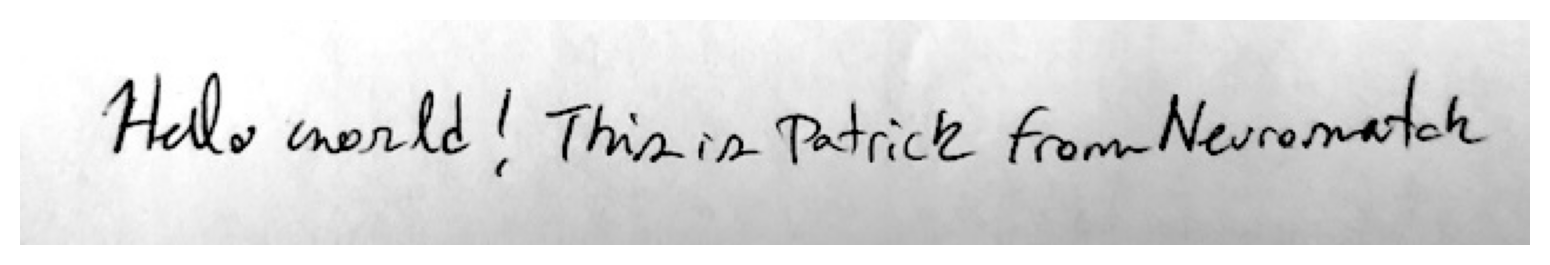

In [17]:
# Usage
image_path = 'img_1235.jpg'
display_image(image_path)

Now, we will apply a few transformations to this image. You can play around with the input values!

In [18]:
# Convert PIL Image to Tensor
image = Image.open(image_path)
image = transforms.ToTensor()(image)

# Define each transformation separately
# RandomAffine: applies rotations, translations, scaling. Here, rotates by up to ±15 degrees,
affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))

# ElasticTransform: applies elastic distortions to the image. The 'alpha' parameter controls
# the intensity of the distortion.
elastic = transforms.ElasticTransform(alpha=50.0)

# RandomPerspective: applies random perspective transformations with a specified distortion scale.
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)

# RandomErasing: randomly erases a rectangle area in the image.
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)

# GaussianBlur: applies gaussian blur with specified kernel size and sigma range.
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.4, 5))

Let's now combine them in a single list and display the images.

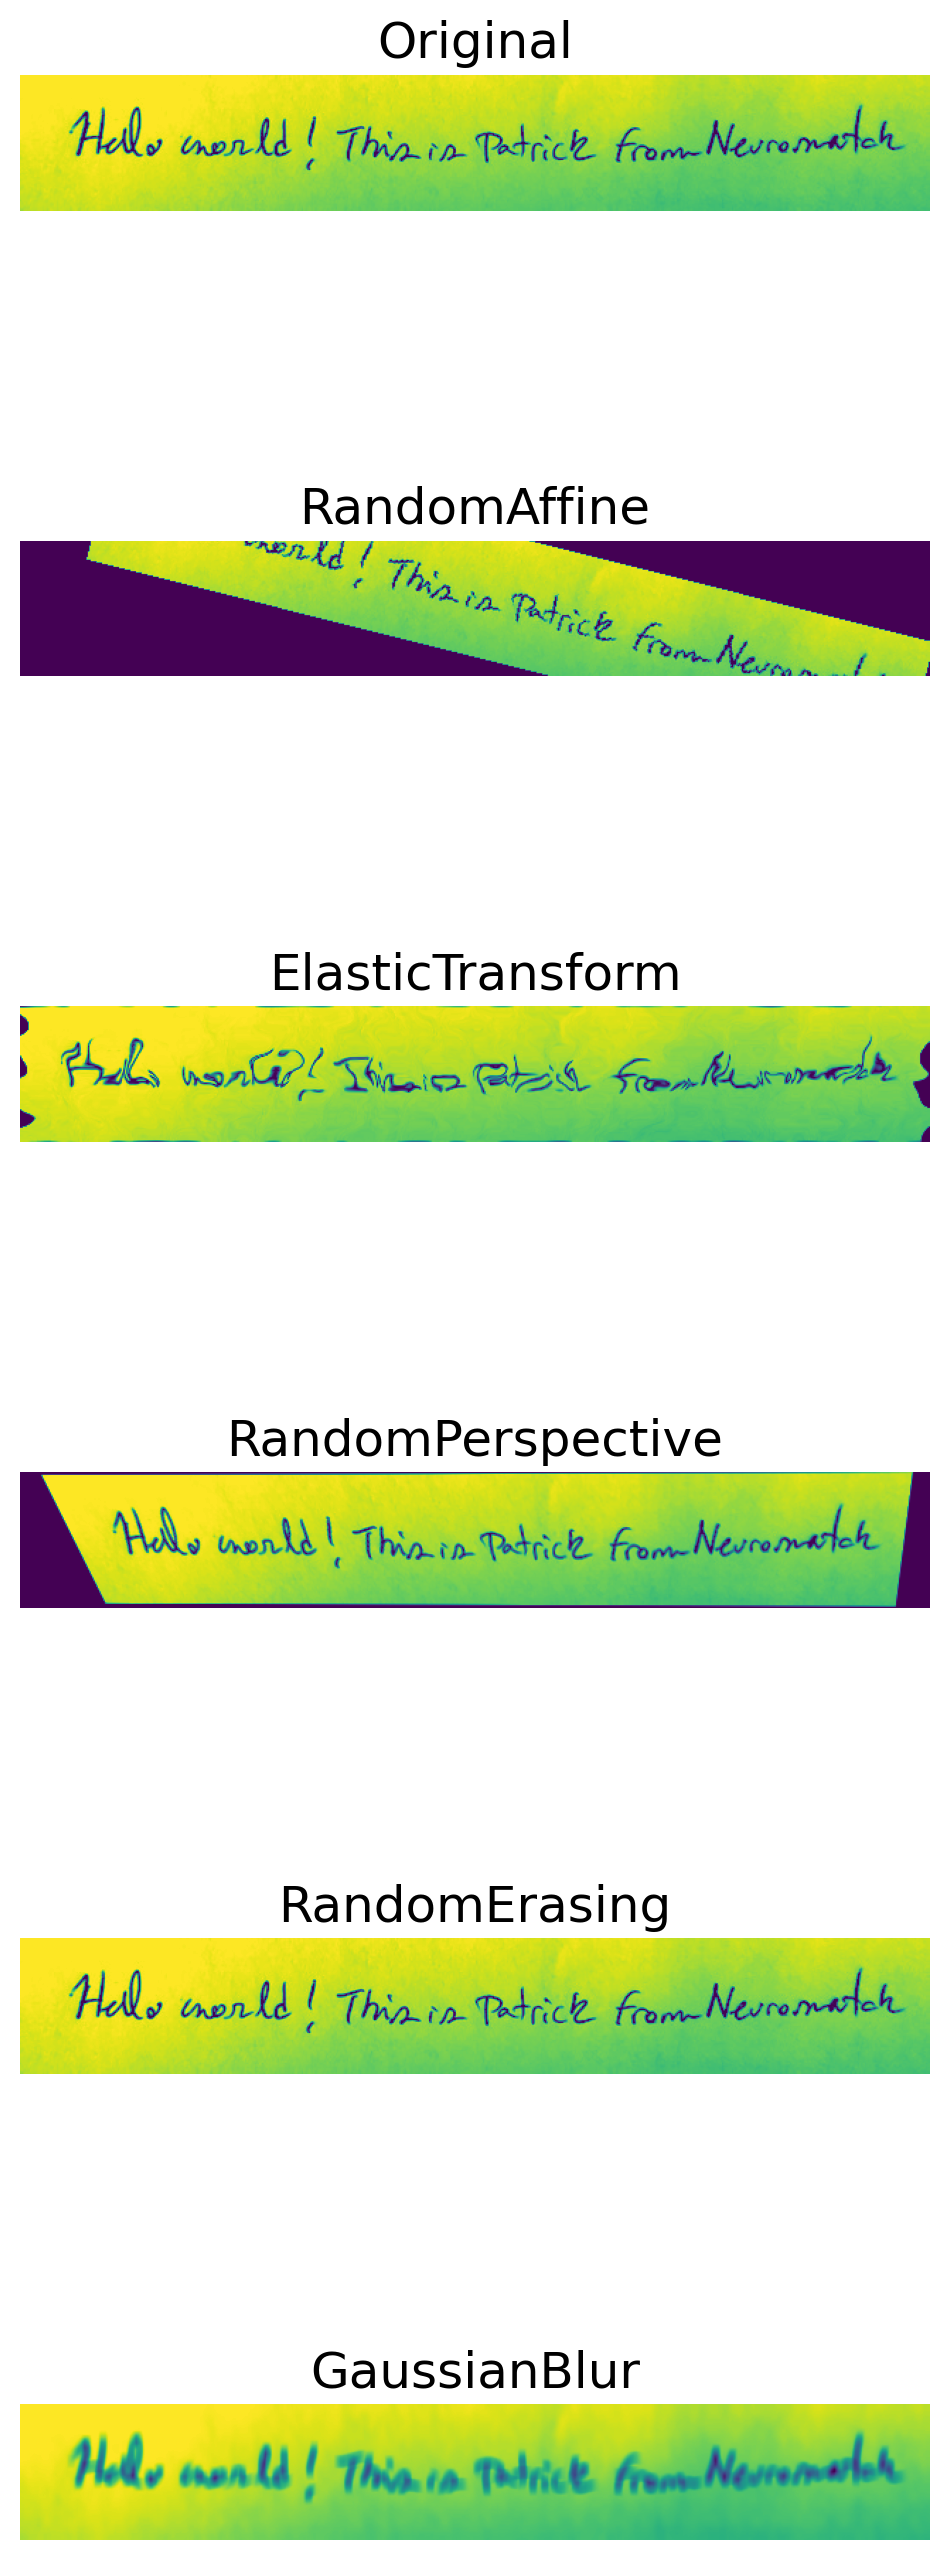

In [19]:
# A list of all transformations for iteration
transformations = [affine, elastic, perspective, erasing, gaussian_blur]

# Display
display_transformed_images(image, transformations)

As you can notice, this images showcase various common data augmentation techniques used in machine learning to increase the diversity of a dataset. Each section represents a transformation applied to the original image:

1. Original: the baseline image without any modifications.
2. RandomAffine: applies random affine transformations to the image, which include translation, scaling, rotation, and shearing. This helps the model become invariant to such transformations in the input data.
3. ElasticTransform: introduces random elastic deformations, simulating non-linear transformations that might occur naturally. It is useful for tasks where we expect such distortions, like medical image analysis.
4. RandomPerspective: changes the perspective from which the image is viewed, simulating the effect of viewing the object from different angles.
5. RandomErasing: randomly removes parts of the image and fills it with some arbitrary pixel values. It can make the model robust against occlusions in the input data.
6. GaussianBlur: applies a Gaussian blur to the image, smoothing it. This can help in reducing high-frequency noise in the images.

These techniques are essential for training robust models, particularly in computer vision, as they help in preventing overfitting and improving the generalization of the model to new, unseen images.

We can also use transforms. Compose from PyTorch to apply all of these transformations simultaneously!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


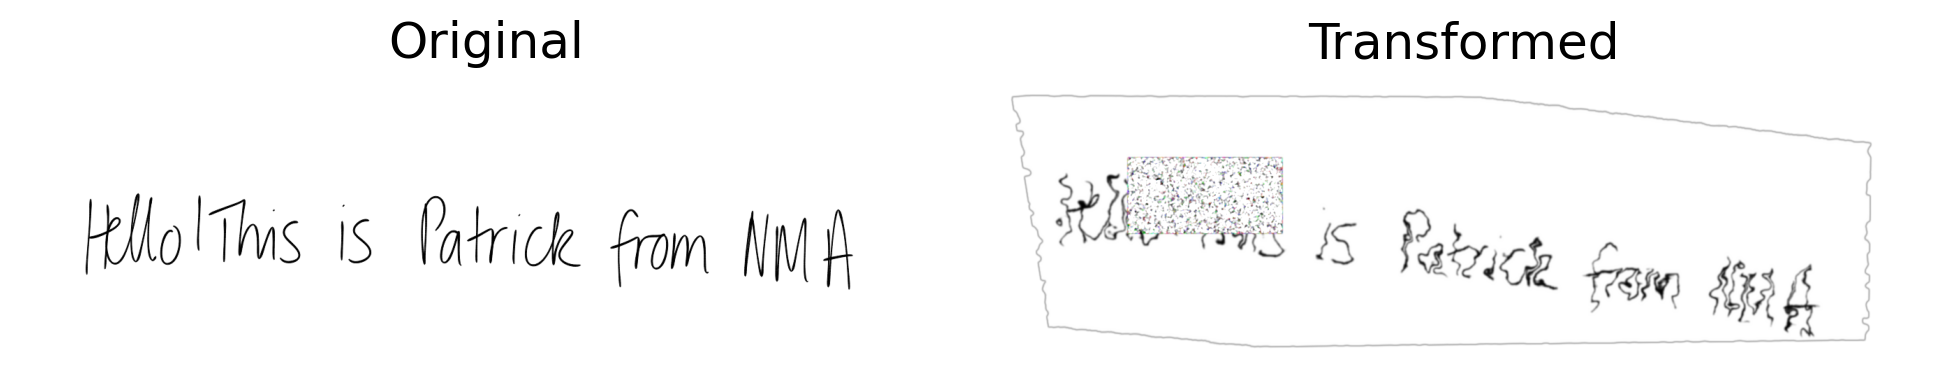

In [20]:
# Path to the image
image_path = 'image_augmentation.png'

# Open the image
image = Image.open(image_path)

# Convert PIL Image to Tensor
image_tensor = transforms.ToTensor()(image)

# Define transformations here
affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
elastic = transforms.ElasticTransform(alpha=90.0)
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

# Combine all the transformations
all_transforms = transforms.Compose([
    affine,
    elastic,
    perspective,
    erasing,
    gaussian_blur
])

# Apply combined transformation
augmented_image_tensor = all_transforms(image_tensor)

display_original_and_transformed_images(image_tensor, augmented_image_tensor)

Now, all those trasnformations are being applied simultaneously.

## Activity 3: Generalization, part III: synthetic data

When augmentation is not enough, we can further improve generalization by training on synthetic data. This allows us to stretch our data even further. 

Crucially, data augmentation creates variations of existing data without changing its inherent properties, while synthetic data generation creates entirely new data that mimics the characteristics of real data.

Here, we will define strings and create a generator to generate a synthetic version of the input data.

In [21]:
# Define your strings
strings = ['Hello', 'This is Patrick', 'From NMA']

# Specify font path
font_path = "DancingScript-VariableFont_wght.ttf"  # Ensure this path is correct

# Create a generator with the specified parameters
generator = GeneratorFromStrings(
    strings=strings,
    fonts=[font_path],
    space_width=2,
    skewing_angle=8,
    count=3
)

# Define the desired size
desired_size = (500, 300)  # Width, Height in pixels

# Function to resize images
def resize_image(image, new_size):
    return image.resize(new_size, Image.Resampling.LANCZOS)

for img, lbl in generator:
    # Resize the image before showing it
    img = resize_image(img, desired_size)
    img.show()

# Call the function with the generator
display_generated_images(generator)

<Figure size 1500x300 with 0 Axes>

### Discussion point

What does this type of synthetic data capture that wouldn’t be easy to capture through data augmentation?

### Generating handwriting style data

We can take this idea further and generate handwriting style data. We will use an embedded calligrapher.ai model to generate new snippets of writing data.

In [22]:
IFrame("https://www.calligrapher.ai/", width=800, height=600)

### Discussion point

What kinds of variation does this synthetic data capture that wouldn’t be easy to reproduce to all our other data generation pipelines?